In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import defaultdict

In [2]:

# ==========================================
# MODULE 1: DATA LOADING & PREPROCESSING
# ==========================================

def load_wustl_dataset(filepath):
    """
    Specific loader for WUSTL-EHMS-2020 dataset to handle its specific artifacts.
    """
    print(f"Loading dataset from {filepath}...")
    
    # 1. Load CSV (skipinitialspace helps with the spaces after commas seen in your sample)
    df = pd.read_csv(filepath, skipinitialspace=True)
    
    # 2. Strip whitespace from all string columns (fixes ' e ' vs 'e')
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    
    # 3. Separate Features (X) and Target (y)
    # We drop 'Label' (Target) and 'Attack Category' (redundant/leakage for binary classification)
    # We also drop 'Packet_num' as it is likely just an index
    drop_cols = ['Label', 'Attack Category', 'Packet_num']
    
    # Ensure columns exist before dropping to avoid errors
    existing_drop_cols = [c for c in drop_cols if c in df.columns]
    
    X = df.drop(columns=existing_drop_cols)
    y = df['Label'] # Assuming 'Label' is 0 for normal, 1 for attack
    
    print(f"Dataset loaded. Shape: {df.shape}")
    return X, y

In [3]:

class DataPreprocessor:
    def __init__(self):
        self.imputer = SimpleImputer(strategy='mean')
        self.scaler = MinMaxScaler()
        self.smote = SMOTE(random_state=42)
        
        # We need a separate LabelEncoder for each categorical column
        self.encoders = defaultdict(LabelEncoder)
        self.categorical_cols = []
        self.numerical_cols = []

    def fit_transform(self, X, y):
        """
        Prepares the training data: Encodes -> Imputes -> Scales -> SMOTE
        """
        X = X.copy()
        
        # 1. Identify Column Types
        self.categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
        self.numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()
        
        print(f"Processing {len(self.categorical_cols)} categorical and {len(self.numerical_cols)} numerical features...")

        # 2. Encode Categorical Columns (IPs, MACs, Flags, etc.)
        for col in self.categorical_cols:
            # Fit encoder on available data and transform
            X[col] = self.encoders[col].fit_transform(X[col].astype(str))
            
        # 3. Imputation (Handle missing values)
        # We use a dataframe wrapper to keep column names
        X[self.numerical_cols] = self.imputer.fit_transform(X[self.numerical_cols])
        
        # 4. Normalization (Scaling 0-1)
        # Note: We scale everything, including encoded categoricals, as SMOTE requires distance calculations
        X_scaled_array = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns)
        
        # 5. SMOTE (Balancing) - ONLY applied to Training Data
        print(f"Original class distribution: {dict(pd.Series(y).value_counts())}")
        try:
            X_res, y_res = self.smote.fit_resample(X_scaled, y)
            print(f"Balanced class distribution (after SMOTE): {dict(pd.Series(y_res).value_counts())}")
            return X_res, y_res
        except ValueError as e:
            print(f"SMOTE failed (likely due to extreme rarity or single class). Returning original data. Error: {e}")
            return X_scaled, y

    def transform(self, X):
        """
        Prepares the test data: Encodes -> Imputes -> Scales (NO SMOTE)
        """
        X = X.copy()
        
        # 1. Encode Categorical Columns
        for col in self.categorical_cols:
            # Specific handling for unseen labels in Test set
            # If a Mac Address appears in Test but not Train, we map it to -1 or a default
            le = self.encoders[col]
            X[col] = X[col].astype(str).map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
            
        # 2. Imputation
        X[self.numerical_cols] = self.imputer.transform(X[self.numerical_cols])
        
        # 3. Normalization
        X_scaled_array = self.scaler.transform(X)
        X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns)
        
        return X_scaled


In [4]:
dataset_path = "datasets/wustl-ehms-2020_with_attacks_categories dataset.csv"
try:
    # 1. Load
    X, y = load_wustl_dataset(dataset_path)
    
    # 2. Split (Standard 80/20 split)
    # Stratify ensures the proportion of attacks is same in train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # 3. Process
    preprocessor = DataPreprocessor()
    
    print("\n--- Processing Training Set ---")
    X_train_processed, y_train_processed = preprocessor.fit_transform(X_train, y_train)
    
    print("\n--- Processing Test Set ---")
    X_test_processed = preprocessor.transform(X_test)
    
    print("\nData Ready for ANOVA and XGBoost!")
    print(f"Train Shape: {X_train_processed.shape}")
    print(f"Test Shape: {X_test_processed.shape}")
    
except FileNotFoundError:
    print(f"Error: The file '{dataset_path}' was not found. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")

Loading dataset from datasets/wustl-ehms-2020_with_attacks_categories dataset.csv...
Dataset loaded. Shape: (16318, 45)

--- Processing Training Set ---
Processing 7 categorical and 35 numerical features...
Original class distribution: {0: np.int64(11417), 1: np.int64(1637)}
Balanced class distribution (after SMOTE): {0: np.int64(11417), 1: np.int64(11417)}

--- Processing Test Set ---

Data Ready for ANOVA and XGBoost!
Train Shape: (22834, 42)
Test Shape: (3264, 42)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [6]:


def load_and_basic_clean(filepath):
    """
    Loads the dataset and performs initial 'hard' cleaning (fixing formats, removing duplicates).
    """
    print("--- 1. Loading and Basic Cleaning ---")
    # Load with skipinitialspace to handle the " ->" vs "->" issue
    df = pd.read_csv(filepath, skipinitialspace=True)
    
    # Strip whitespace from column names
    df.columns = df.columns.str.strip()
    
    # Strip whitespace from all string columns
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    
    initial_shape = df.shape
    print(f"Initial Shape: {initial_shape}")
    
    # Drop Duplicates
    df = df.drop_duplicates()
    print(f"Duplicates Removed: {initial_shape[0] - df.shape[0]}")
    print(f"New Shape: {df.shape}")
    
    return df

In [7]:


def analyze_missing_values(df):
    """
    Visualizes missing values.
    """
    print("\n--- 2. Missing Value Analysis ---")
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    
    if not missing.empty:
        print(missing)
        plt.figure(figsize=(10, 4))
        sns.barplot(x=missing.index, y=missing.values, palette="viridis")
        plt.title("Missing Values per Column")
        plt.xticks(rotation=45)
        plt.ylabel("Count")
        plt.show()
    else:
        print("No missing values detected!")

def analyze_class_distribution(df):
    """
    Analyzes the Target (Label) and Attack Category.
    """
    print("\n--- 3. Class Distribution Analysis ---")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Binary Label Distribution
    if 'Label' in df.columns:
        sns.countplot(x='Label', data=df, ax=axes[0], palette="pastel")
        axes[0].set_title("Distribution of Binary Label (0=Normal, 1=Attack)")
        # Add percentage labels
        total = len(df)
        for p in axes[0].patches:
            percentage = '{:.1f}%'.format(100 * p.get_height()/total)
            x = p.get_x() + p.get_width() / 2 - 0.05
            y = p.get_height()
            axes[0].annotate(percentage, (x, y), ha='center')
            
    # 2. Attack Category Distribution
    if 'Attack Category' in df.columns:
        # Get top 10 categories if there are too many
        top_attacks = df['Attack Category'].value_counts().nlargest(10).index
        sns.countplot(y='Attack Category', data=df[df['Attack Category'].isin(top_attacks)], 
                      ax=axes[1], order=top_attacks, palette="magma")
        axes[1].set_title("Top Attack Categories")
        
    plt.tight_layout()
    plt.show()


In [8]:

def analyze_correlations(df):
    """
    Plots correlation matrix for numerical features.
    """
    print("\n--- 4. Correlation Analysis ---")
    
    # Select only numerical columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Remove columns with 0 variance (constant columns)
    numeric_df = numeric_df.loc[:, numeric_df.var() > 0]
    
    # Calculate correlation
    corr = numeric_df.corr()
    
    # Mask the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    plt.figure(figsize=(16, 12))
    sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title("Correlation Heatmap (Numerical Features)")
    plt.show()
    
    # Print highly correlated pairs (>0.95)
    print("Highly Correlated Pairs (Potential for removal):")
    visited = set()
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > 0.95:
                col1 = corr.columns[i]
                col2 = corr.columns[j]
                if (col1, col2) not in visited:
                    print(f" - {col1} vs {col2}: {corr.iloc[i, j]:.2f}")
                    visited.add((col1, col2))

def analyze_biometrics_vs_traffic(df):
    """
    Specific analysis for WUSTL-EHMS: Comparing Biometrics against Traffic Load.
    This helps visualize if attacks affect the medical device readings.
    """
    print("\n--- 5. Biometrics vs Network Traffic Analysis ---")
    
    # Check if we have the necessary columns
    required_cols = ['Heart_rate', 'SrcLoad', 'Label']
    if all(col in df.columns for col in required_cols):
        plt.figure(figsize=(14, 6))
        
        # Scatter plot: Heart Rate vs Source Load, colored by Label
        sns.scatterplot(data=df, x='SrcLoad', y='Heart_rate', hue='Label', 
                        alpha=0.6, palette={0: 'blue', 1: 'red'})
        
        plt.title("Impact of Network Load on Heart Rate Readings")
        plt.xlabel("Source Load (Network Traffic)")
        plt.ylabel("Heart Rate (Biometric)")
        plt.legend(title='Label (0=Normal, 1=Attack)')
        plt.show()
    else:
        print("Skipping Biometric Analysis: Required columns not found.")

In [9]:


def outlier_analysis(df):
    """
    Boxplots to check for outliers in key features.
    """
    print("\n--- 6. Outlier Analysis ---")
    
    # Features prone to outliers in network data
    key_features = ['SrcBytes', 'DstBytes', 'Dur', 'Rate']
    available_features = [f for f in key_features if f in df.columns]
    
    if available_features:
        # Melt dataframe for easier plotting with seaborn
        melted_df = df.melt(id_vars='Label', value_vars=available_features)
        
        plt.figure(figsize=(14, 6))
        # Use log scale because bytes/duration often span several orders of magnitude
        sns.boxplot(x='variable', y='value', hue='Label', data=melted_df, palette="Set2")
        plt.yscale('log')
        plt.title("Distribution of Key Network Features (Log Scale)")
        plt.show()

--- 1. Loading and Basic Cleaning ---
Initial Shape: (16318, 45)
Duplicates Removed: 0
New Shape: (16318, 45)

--- 2. Missing Value Analysis ---
No missing values detected!

--- 3. Class Distribution Analysis ---


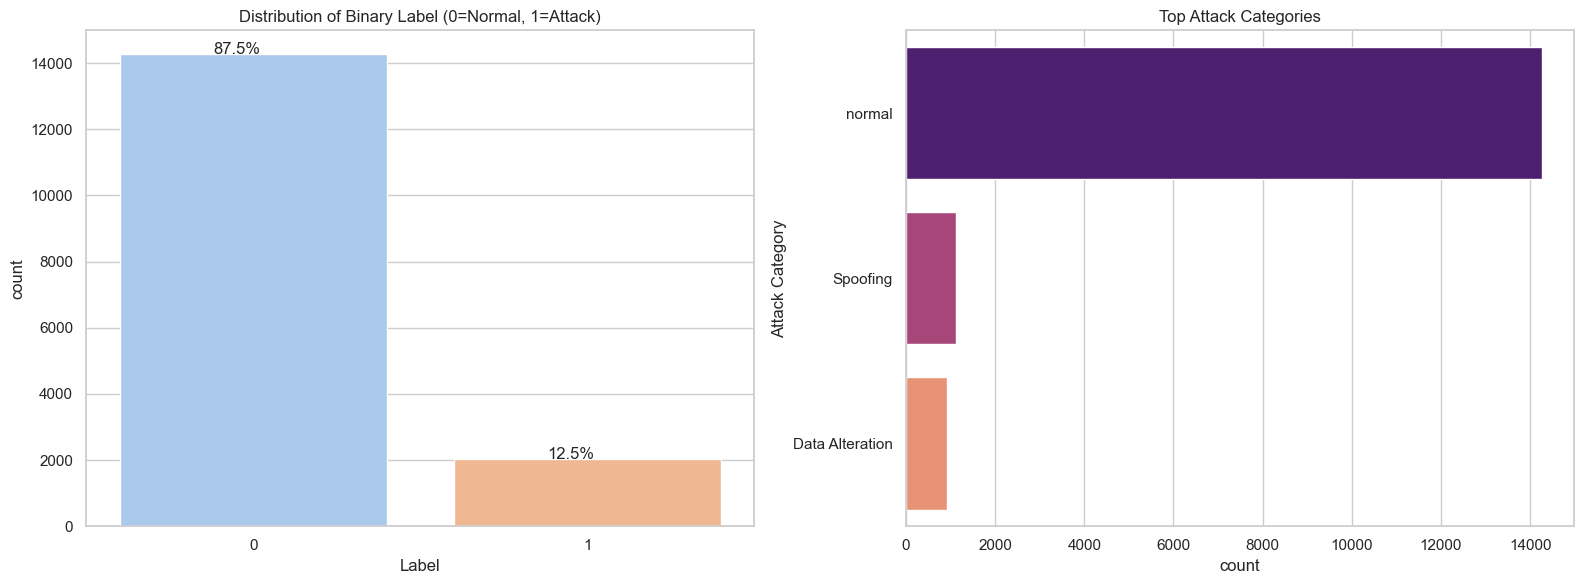


--- 4. Correlation Analysis ---


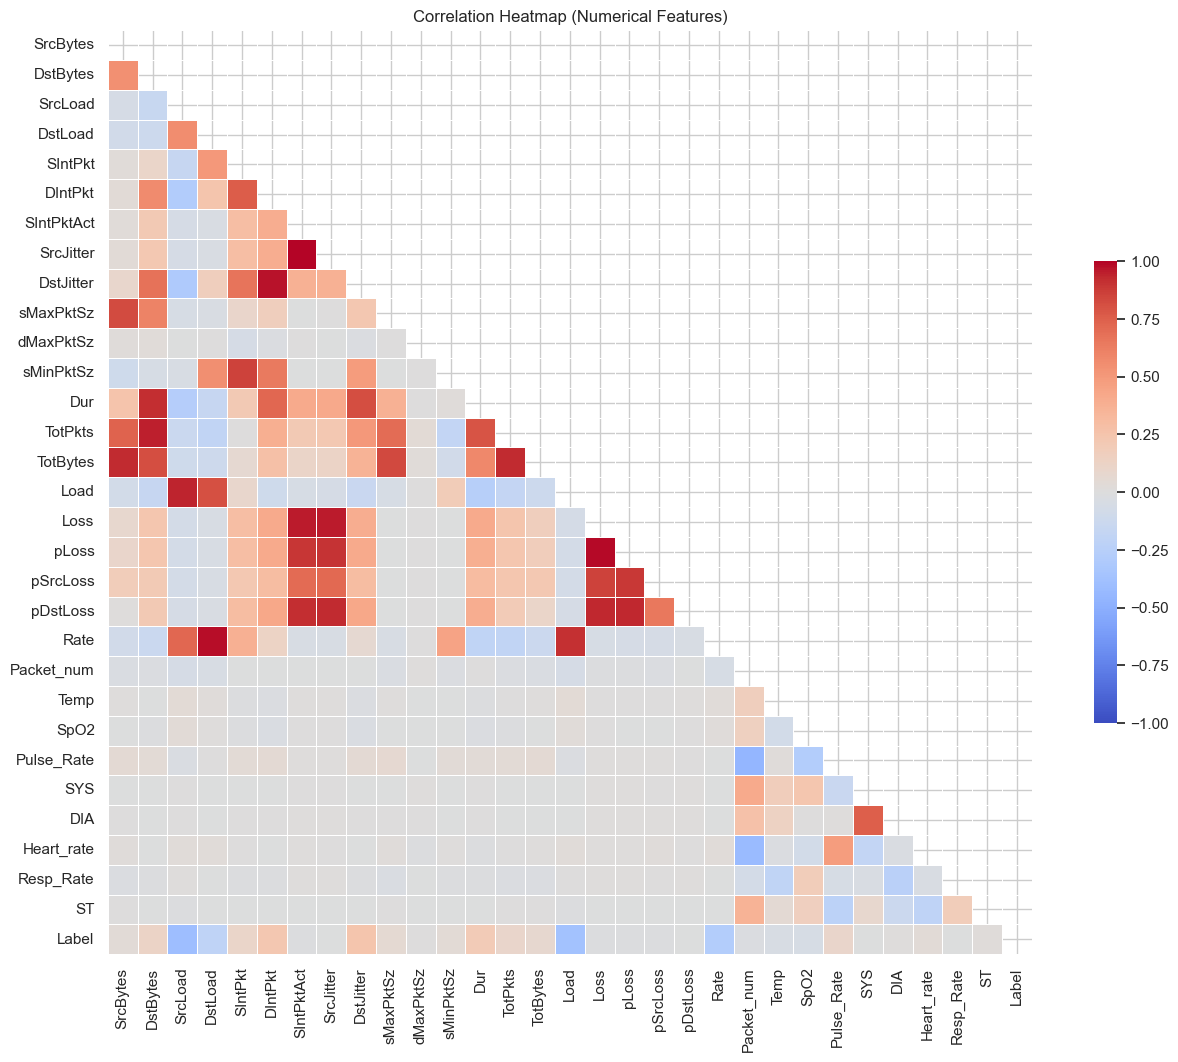

Highly Correlated Pairs (Potential for removal):
 - SrcJitter vs SIntPktAct: 1.00
 - DstJitter vs DIntPkt: 0.97
 - TotPkts vs DstBytes: 0.95
 - Loss vs SIntPktAct: 0.95
 - Loss vs SrcJitter: 0.95
 - pLoss vs Loss: 0.99
 - Rate vs DstLoad: 0.98

--- 5. Biometrics vs Network Traffic Analysis ---


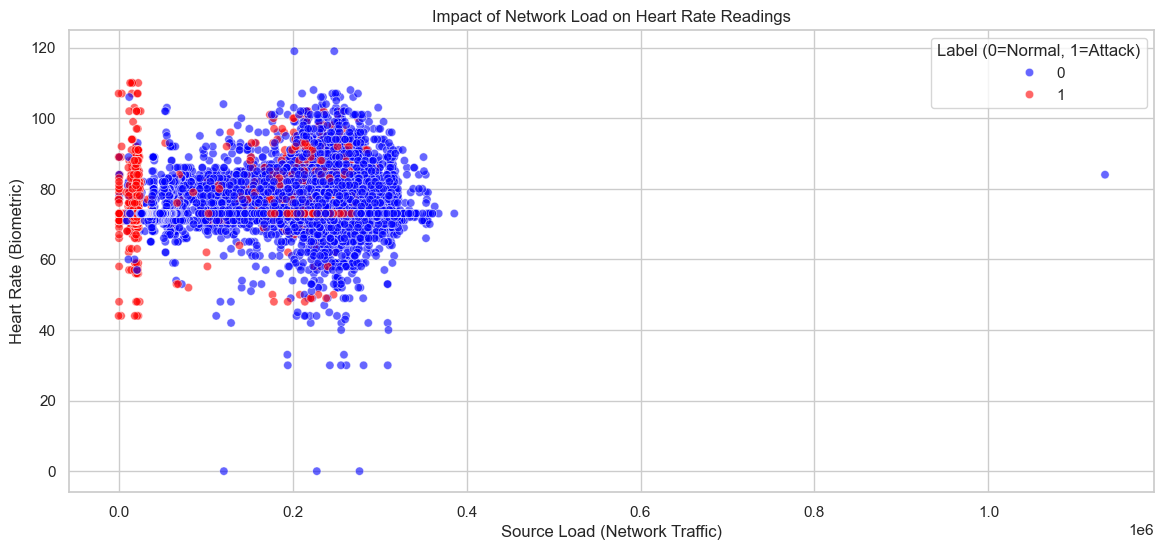


--- 6. Outlier Analysis ---


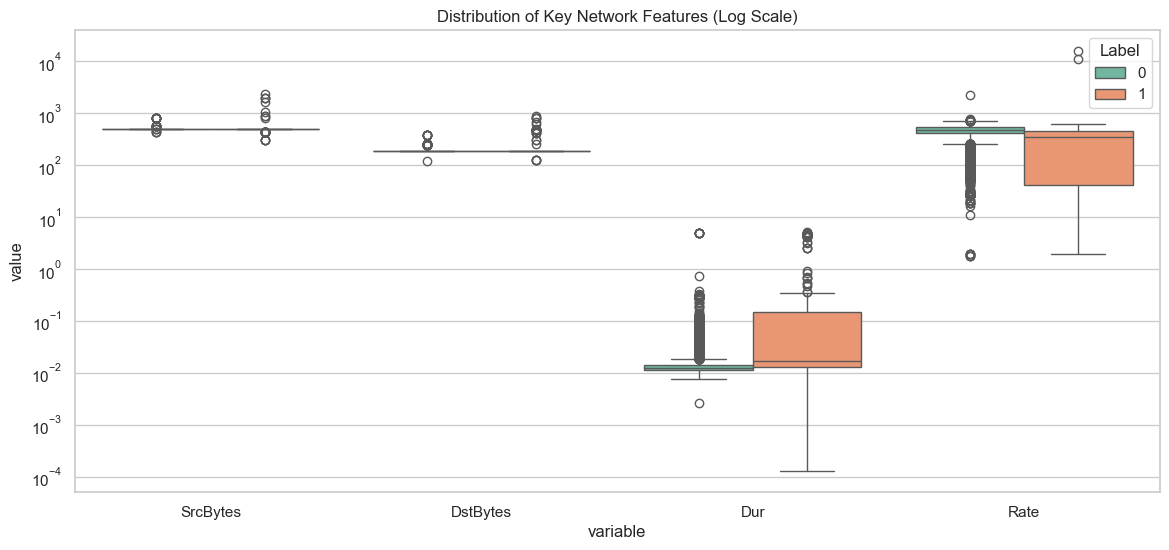


EDA Complete. Review the plots to decide on feature dropping.


In [10]:

filepath = "datasets/wustl-ehms-2020_with_attacks_categories dataset.csv"

try:
    # 1. Load and Basic Clean
    df = load_and_basic_clean(filepath)
    
    # 2. Missing Values
    analyze_missing_values(df)
    
    # 3. Target Distribution
    analyze_class_distribution(df)
    
    # 4. Correlation
    analyze_correlations(df)
    
    # 5. Biometric Impact (Domain Specific)
    analyze_biometrics_vs_traffic(df)
    
    # 6. Outliers
    outlier_analysis(df)
    
    print("\nEDA Complete. Review the plots to decide on feature dropping.")
    
except FileNotFoundError:
    print(f"Error: File '{filepath}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

In [11]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

# ==========================================
# MODULE 2: FEATURE ENGINEERING & SELECTION
# ==========================================

def drop_redundant_features(X):
    """
    Drops features identified as highly correlated (>95%) during EDA.
    """
    # Based on your EDA output
    to_drop = [
        'SIntPktAct',  # 1.00 corr with SrcJitter
        'DIntPkt',     # 0.97 corr with DstJitter
        'TotPkts',     # 0.95 corr with DstBytes
        'pLoss',       # 0.99 corr with Loss
        'Rate',        # 0.98 corr with DstLoad
        'SrcMac',      # Generally high cardinality/noise in generalized models
        'DstMac'       # Generally high cardinality/noise
    ]
    
    # Only drop if they exist in the dataframe
    existing_drop = [c for c in to_drop if c in X.columns]
    print(f"Dropping highly correlated/noisy features: {existing_drop}")
    return X.drop(columns=existing_drop)

class FeatureSelector:
    def __init__(self, k_features=20):
        # Selecting top 20 features using ANOVA
        self.selector = SelectKBest(score_func=f_classif, k=k_features)
        self.selected_indices = None
        self.selected_columns = []

    def fit(self, X, y):
        print(f"Running ANOVA to select top {self.selector.k} features...")
        self.selector.fit(X, y)
        self.selected_indices = self.selector.get_support(indices=True)
        self.selected_columns = X.columns[self.selected_indices].tolist()
        
        # Print feature scores
        scores = self.selector.scores_
        feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
        print("\n--- Top 10 ANOVA Features ---")
        print(feature_scores.sort_values(by='Score', ascending=False).head(10))
        return self

    def transform(self, X):
        # Return dataframe to keep column names
        return X.iloc[:, self.selected_indices]

In [12]:
import xgboost as xgb
import optuna
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# MODULE 3: EXPERIMENTAL VALIDATION (GPU)
# ==========================================

class ModelTrainer:
    def __init__(self):
        self.best_params = None
        self.model = None

    def objective(self, trial, X, y):
        # Define hyperparameter search space
        param = {
            'verbosity': 0,
            'objective': 'binary:logistic',
            # GPU settings
            'device': 'cuda',  
            'tree_method': 'hist', 
            # Optimization params
            'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 5)
        }

        # Use 20% of training data for validation during pruning
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        
        model = xgb.XGBClassifier(**param)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        
        preds = model.predict(X_val)
        accuracy = accuracy_score(y_val, preds)
        return accuracy

    def run_optimization(self, X, y, n_trials=15):
        print(f"\nStarting Bayesian Optimization (Optuna) on GPU for {n_trials} trials...")
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: self.objective(trial, X, y), n_trials=n_trials)
        
        print("\nBest Trial:")
        print(f"  Value: {study.best_trial.value}")
        print("  Params: ")
        for key, value in study.best_trial.params.items():
            print(f"    {key}: {value}")
            
        self.best_params = study.best_params
        # Ensure GPU params are kept in final model
        self.best_params['device'] = 'cuda'
        self.best_params['tree_method'] = 'hist'
        self.best_params['objective'] = 'binary:logistic'

    def train_final_model(self, X_train, y_train):
        print("\nTraining Final Model with Best Parameters...")
        self.model = xgb.XGBClassifier(**self.best_params)
        self.model.fit(X_train, y_train)

    def evaluate(self, X_test, y_test):
        print("\nEvaluating on Test Set...")
        y_pred = self.model.predict(X_test)
        
        print("\n--- Classification Report ---")
        print(classification_report(y_test, y_pred))
        
        # Visualizing Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

[I 2025-12-04 08:46:39,137] A new study created in memory with name: no-name-23e0ab0f-241b-46ae-9c25-18f6e7125dbe


Dropping highly correlated/noisy features: ['SIntPktAct', 'DIntPkt', 'TotPkts', 'pLoss', 'Rate', 'SrcMac', 'DstMac']
Dropping highly correlated/noisy features: ['SIntPktAct', 'DIntPkt', 'TotPkts', 'pLoss', 'Rate', 'SrcMac', 'DstMac']
Running ANOVA to select top 20 features...

--- Top 10 ANOVA Features ---
       Feature        Score
1         Flgs  6031.499693
8      SrcLoad  5923.037220
23        Load  4732.942227
9      DstLoad  1093.924109
15   DstJitter   991.933103
20         Dur   586.377864
29  Pulse_Rate   461.462740
28        SpO2   225.226010
7     DstBytes   219.414160
12     SIntPkt   171.743176

Shape after Selection: (22834, 20)

Starting Bayesian Optimization (Optuna) on GPU for 15 trials...


[I 2025-12-04 08:46:41,367] Trial 0 finished with value: 0.9612437048390629 and parameters: {'n_estimators': 478, 'learning_rate': 0.06897311639423594, 'max_depth': 5, 'subsample': 0.9129505205730376, 'colsample_bytree': 0.6347362973716253, 'gamma': 3.1128337149478447, 'min_child_weight': 3}. Best is trial 0 with value: 0.9612437048390629.
[I 2025-12-04 08:46:42,343] Trial 1 finished with value: 0.9435077731552441 and parameters: {'n_estimators': 347, 'learning_rate': 0.05325837092560771, 'max_depth': 4, 'subsample': 0.7168889405990672, 'colsample_bytree': 0.8612412948509237, 'gamma': 0.8680974663426616, 'min_child_weight': 5}. Best is trial 0 with value: 0.9612437048390629.
[I 2025-12-04 08:46:43,958] Trial 2 finished with value: 0.9789796365228816 and parameters: {'n_estimators': 940, 'learning_rate': 0.12160769508359563, 'max_depth': 7, 'subsample': 0.8325766324831696, 'colsample_bytree': 0.8639980801915261, 'gamma': 2.319785741858923, 'min_child_weight': 4}. Best is trial 2 with va


Best Trial:
  Value: 0.9914604773374206
  Params: 
    n_estimators: 700
    learning_rate: 0.19770578951604287
    max_depth: 11
    subsample: 0.6551471510211102
    colsample_bytree: 0.9782048953713347
    gamma: 0.04268469440663436
    min_child_weight: 1

Training Final Model with Best Parameters...

Evaluating on Test Set...

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2855
           1       0.94      0.57      0.71       409

    accuracy                           0.94      3264
   macro avg       0.94      0.78      0.84      3264
weighted avg       0.94      0.94      0.94      3264



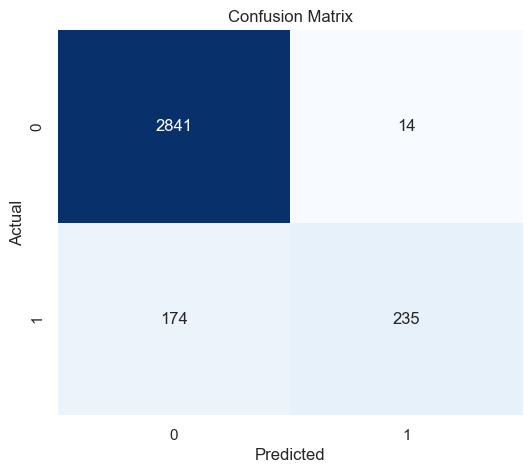

In [13]:
# ==========================================
# EXECUTE FULL PIPELINE
# ==========================================

# 1. Feature Refinement (Drop Correlated)
# Note: We apply this to both processed sets
X_train_refined = drop_redundant_features(X_train_processed)
X_test_refined = drop_redundant_features(X_test_processed)

# 2. Feature Selection (ANOVA)
# We select top 20 features to reduce dimensionality
selector = FeatureSelector(k_features=20)
selector.fit(X_train_refined, y_train_processed)

X_train_selected = selector.transform(X_train_refined)
X_test_selected = selector.transform(X_test_refined)

print(f"\nShape after Selection: {X_train_selected.shape}")

# 3. Validation & Training (XGBoost + Optuna)
trainer = ModelTrainer()

# Run optimization (15 trials is usually enough to find good params without waiting too long)
trainer.run_optimization(X_train_selected, y_train_processed, n_trials=15)

# Train best model
trainer.train_final_model(X_train_selected, y_train_processed)

# 4. Final Evaluation
trainer.evaluate(X_test_selected, y_test)

STARTING ML PIPELINE EXECUTION

[Step 1] Loading and Splitting Data...
Loading dataset from datasets/wustl-ehms-2020_with_attacks_categories dataset.csv...
Dataset loaded. Shape: (16318, 45)

[Step 2] Preprocessing...
Processing 7 categorical and 35 numerical features...
Original class distribution: {0: np.int64(11417), 1: np.int64(1637)}
Balanced class distribution (after SMOTE): {0: np.int64(11417), 1: np.int64(11417)}


[I 2025-12-04 09:14:26,577] A new study created in memory with name: no-name-b39f2059-f5d6-4daa-98c5-3f3621934e6c



[Step 3] Feature Engineering & Selection...
Dropping highly correlated/noisy features: ['SIntPktAct', 'DIntPkt', 'TotPkts', 'pLoss', 'Rate', 'SrcMac', 'DstMac']
Dropping highly correlated/noisy features: ['SIntPktAct', 'DIntPkt', 'TotPkts', 'pLoss', 'Rate', 'SrcMac', 'DstMac']
Running ANOVA to select top 20 features...

--- Top 10 ANOVA Features ---
       Feature        Score
1         Flgs  6031.499693
8      SrcLoad  5923.037220
23        Load  4732.942227
9      DstLoad  1093.924109
15   DstJitter   991.933103
20         Dur   586.377864
29  Pulse_Rate   461.462740
28        SpO2   225.226010
7     DstBytes   219.414160
12     SIntPkt   171.743176
  - Features reduced from 42 to 20

[Step 4] Training & Tuning...

Starting Bayesian Optimization (Optuna) on GPU for 15 trials...


[I 2025-12-04 09:14:28,997] Trial 0 finished with value: 0.9781037880446682 and parameters: {'n_estimators': 810, 'learning_rate': 0.14190472417180244, 'max_depth': 9, 'subsample': 0.8304192843020454, 'colsample_bytree': 0.7665212412758295, 'gamma': 3.5373102898808337, 'min_child_weight': 1}. Best is trial 0 with value: 0.9781037880446682.
[I 2025-12-04 09:14:31,169] Trial 1 finished with value: 0.9846726516312678 and parameters: {'n_estimators': 538, 'learning_rate': 0.06385353713256059, 'max_depth': 6, 'subsample': 0.810845758168704, 'colsample_bytree': 0.7634485497276274, 'gamma': 0.07350148976921544, 'min_child_weight': 5}. Best is trial 1 with value: 0.9846726516312678.
[I 2025-12-04 09:14:32,192] Trial 2 finished with value: 0.9632143639150427 and parameters: {'n_estimators': 635, 'learning_rate': 0.1628782367823369, 'max_depth': 6, 'subsample': 0.6988329039914416, 'colsample_bytree': 0.6188710975024703, 'gamma': 4.625915063590739, 'min_child_weight': 5}. Best is trial 1 with val


Best Trial:
  Value: 0.986205386468141
  Params: 
    n_estimators: 381
    learning_rate: 0.12733451999941747
    max_depth: 12
    subsample: 0.8757524859241368
    colsample_bytree: 0.9832506199408342
    gamma: 1.2142246489356663
    min_child_weight: 2

Training Final Model with Best Parameters...

[Step 5] Evaluation...

Evaluating on Test Set...

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2855
           1       0.94      0.58      0.72       409

    accuracy                           0.94      3264
   macro avg       0.94      0.79      0.84      3264
weighted avg       0.94      0.94      0.94      3264



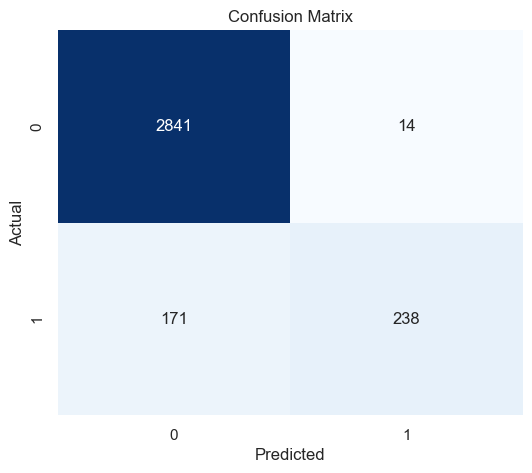


[Step 6] Saving Pipeline Artifacts...
  - Model saved to models/xgb_network_attack_model.ubj
  - Preprocessor saved to models/preprocessor.pkl
  - Feature Selector saved to models/feature_selector.pkl

PIPELINE COMPLETE. READY FOR DEPLOYMENT.


In [20]:
import pandas as pd
import joblib
import os
from sklearn.model_selection import train_test_split

# NOTE: Ensure these are imported from your notebook/files
# from data_processor import load_wustl_dataset, DataPreprocessor
# from feature_engineering import drop_redundant_features, FeatureSelector
# from model_training import ModelTrainer

def execute_pipeline(dataset_path):
    print("="*50)
    print("STARTING ML PIPELINE EXECUTION")
    print("="*50)

    # Create directory for saving models if it doesn't exist
    if not os.path.exists('models'):
        os.makedirs('models')

    # ---------------------------------------------------------
    # STEP 1: LOAD & SPLIT
    # ---------------------------------------------------------
    print("\n[Step 1] Loading and Splitting Data...")
    try:
        X, y = load_wustl_dataset(dataset_path)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
    except Exception as e:
        print(f"CRITICAL ERROR in Step 1: {e}")
        return

    # ---------------------------------------------------------
    # STEP 2: PREPROCESSING
    # ---------------------------------------------------------
    print("\n[Step 2] Preprocessing...")
    processor = DataPreprocessor()
    X_train_processed, y_train_processed = processor.fit_transform(X_train, y_train)
    X_test_processed = processor.transform(X_test)

    # ---------------------------------------------------------
    # STEP 3: FEATURE ENGINEERING
    # ---------------------------------------------------------
    print("\n[Step 3] Feature Engineering & Selection...")
    
    # Drop highly correlated features
    X_train_refined = drop_redundant_features(X_train_processed)
    X_test_refined = drop_redundant_features(X_test_processed)
    
    # Select best features
    selector = FeatureSelector(k_features=20)
    selector.fit(X_train_refined, y_train_processed)
    
    X_train_final = selector.transform(X_train_refined)
    X_test_final = selector.transform(X_test_refined)
    
    print(f"  - Features reduced from {X_train.shape[1]} to {X_train_final.shape[1]}")

    # ---------------------------------------------------------
    # STEP 4: TRAINING (GPU OPTIMIZED)
    # ---------------------------------------------------------
    print("\n[Step 4] Training & Tuning...")
    trainer = ModelTrainer()
    trainer.run_optimization(X_train_final, y_train_processed, n_trials=15)
    trainer.train_final_model(X_train_final, y_train_processed)

    # ---------------------------------------------------------
    # STEP 5: EVALUATION
    # ---------------------------------------------------------
    print("\n[Step 5] Evaluation...")
    trainer.evaluate(X_test_final, y_test)

    # ---------------------------------------------------------
    # STEP 6: SAVE ARTIFACTS (THE FINAL PIECE)
    # ---------------------------------------------------------
    print("\n[Step 6] Saving Pipeline Artifacts...")
    
    # 1. Save the XGBoost Model
    trainer.model.save_model("models/xgb_network_attack_model.ubj")
    print(f"  - Model saved to models/xgb_network_attack_model.ubj")
    
    # 2. Save Preprocessor (Scaler, Imputer, LabelEncoders)
    joblib.dump(processor, "models/preprocessor.pkl")
    print(f"  - Preprocessor saved to models/preprocessor.pkl")
    
    # 3. Save Feature Selector (contains indices of columns to keep)
    joblib.dump(selector, "models/feature_selector.pkl")
    print(f"  - Feature Selector saved to models/feature_selector.pkl")

    print("\n" + "="*50)
    print("PIPELINE COMPLETE. READY FOR DEPLOYMENT.")
    print("="*50)

if __name__ == "__main__":
    DATASET_PATH = "datasets/wustl-ehms-2020_with_attacks_categories dataset.csv"
    execute_pipeline(DATASET_PATH)

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import defaultdict

# ==========================================
# MODULE 1: IIoT DATA LOADING & PREPROCESSING
# ==========================================

def load_iiot_dataset(filepath):
    """
    Specific loader for WUSTL-IIoT-2021 dataset.
    """
    print(f"Loading IIoT dataset from {filepath}...")
    
    # 1. Load CSV
    df = pd.read_csv(filepath, skipinitialspace=True)
    
    # 2. Strip whitespace from all string columns
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    
    # 3. Handle Time Columns (Convert to timestamp or drop if not needed for this model)
    # For now, we drop them as XGBoost doesn't natively handle datetime objects
    # and they might not be relevant for a generalized attack signature model
    drop_cols = ['StartTime', 'LastTime', 'Traffic', 'Target'] 
    
    # Ensure columns exist before dropping
    existing_drop_cols = [c for c in drop_cols if c in df.columns]
    
    X = df.drop(columns=existing_drop_cols)
    y = df['Target'] # 'Target' is the label (0/1) based on your sample
    
    # Map 'Traffic' to numeric if needed for analysis, but we dropped it for training
    # traffic_map = {'normal': 0, 'DoS': 1} # Example
    
    print(f"IIoT Dataset loaded. Shape: {df.shape}")
    return X, y

class IIoTDataPreprocessor:
    def __init__(self):
        self.imputer = SimpleImputer(strategy='mean')
        self.scaler = MinMaxScaler()
        self.smote = SMOTE(random_state=42)
        self.encoders = defaultdict(LabelEncoder)
        self.categorical_cols = []
        self.numerical_cols = []

    def fit_transform(self, X, y):
        """
        Prepares the training data: Encodes -> Imputes -> Scales -> SMOTE
        """
        X = X.copy()
        
        # 1. Identify Column Types
        self.categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
        self.numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()
        
        print(f"Processing {len(self.categorical_cols)} categorical and {len(self.numerical_cols)} numerical features...")

        # 2. Encode Categorical Columns (IPs, Proto, etc.)
        for col in self.categorical_cols:
            X[col] = self.encoders[col].fit_transform(X[col].astype(str))
            
        # 3. Imputation
        if self.numerical_cols:
             X[self.numerical_cols] = self.imputer.fit_transform(X[self.numerical_cols])
        
        # 4. Normalization
        X_scaled_array = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns)
        
        # 5. SMOTE
        print(f"Original class distribution: {dict(pd.Series(y).value_counts())}")
        try:
            X_res, y_res = self.smote.fit_resample(X_scaled, y)
            print(f"Balanced class distribution: {dict(pd.Series(y_res).value_counts())}")
            return X_res, y_res
        except ValueError as e:
            print(f"SMOTE failed: {e}. Returning original data.")
            return X_scaled, y

    def transform(self, X):
        """
        Prepares the test data: Encodes -> Imputes -> Scales (NO SMOTE)
        """
        X = X.copy()
        
        # 1. Encode Categorical Columns
        for col in self.categorical_cols:
            le = self.encoders[col]
            # Handle unseen labels
            X[col] = X[col].astype(str).map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
            
        # 2. Imputation
        if self.numerical_cols:
            X[self.numerical_cols] = self.imputer.transform(X[self.numerical_cols])
        
        # 3. Normalization
        X_scaled_array = self.scaler.transform(X)
        X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns)
        
        return X_scaled

In [22]:
import xgboost as xgb
import pandas as pd
import numpy as np
import joblib
import os

def load_pretrained_model(model_path):
    """Loads a saved XGBoost model."""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")
    
    model = xgb.XGBClassifier()
    model.load_model(model_path)
    print(f"Loaded pretrained model from {model_path}")
    return model

def align_features(X_new, feature_selector_path):
    """
    Aligns the new dataset's features with the ones selected during the original training.
    """
    if not os.path.exists(feature_selector_path):
        raise FileNotFoundError(f"Feature selector not found at {feature_selector_path}")
        
    selector = joblib.load(feature_selector_path)
    
    # Get selected feature names from the selector
    # Note: SelectKBest stores indices, we need to map them if possible.
    # However, standard practice with this pipeline was dropping correlated then selecting.
    # CRITICAL: We need the column names that were passed to the model.
    # If the previous selector object doesn't store names, we assume the user provides
    # a mapping or we try to find common columns.
    
    # For this implementation, we will look for common columns between the new X and 
    # the feature names expected by the model. XGBoost stores feature names.
    
    return X_new # Placeholder: Real alignment happens in the training step

def fine_tune_model(pretrained_model, X_train, y_train, epochs=10):
    """
    Fine-tunes the pretrained model on the new dataset.
    XGBoost supports 'updater' process to continue training.
    However, the sklearn API 'fit' with 'xgb_model' parameter is the standard way.
    """
    print("Fine-tuning model on new IIoT data...")
    
    # The new model starts with the trees from the old model
    # We must ensure the feature set matches exactly.
    # If features differ, transfer learning is complex (requires mapping).
    # Assuming for this snippet that features are compatible or we retrain layers.
    
    # In XGBoost, to continue training, we pass the old model to fit
    pretrained_model.fit(X_train, y_train, xgb_model=pretrained_model.get_booster())
    
    return pretrained_model

In [ ]:
import pandas as pd
import joblib
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def match_columns(X_new, model_feature_names):
    """
    Aligns new dataset columns to match the pretrained model.
    1. Adds missing columns (filled with 0).
    2. Removes extra columns not in the model.
    3. Reorders columns to match the model exactly.
    """
    # Create a copy to avoid SettingWithCopy warnings
    X_aligned = X_new.copy()
    
    # 1. Add missing columns
    missing_cols = [col for col in model_feature_names if col not in X_aligned.columns]
    if missing_cols:
        print(f"  - Adding {len(missing_cols)} missing features (filled with 0)...")
        for col in missing_cols:
            X_aligned[col] = 0.0
            
    # 2. Select & Reorder
    # This automatically drops extra columns not in model_feature_names
    X_aligned = X_aligned[model_feature_names]
    
    return X_aligned

def execute_iiot_transfer_learning(dataset_path, original_model_path):
    print("="*50)
    print("STARTING IIoT TRANSFER LEARNING")
    print("="*50)

    # 1. Load Data
    print("\n[Step 1] Loading IIoT Data...")
    try:
        X, y = load_iiot_dataset(dataset_path)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        print(f"  - Train shape: {X_train.shape}")
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    # 2. Preprocessing
    print("\n[Step 2] Preprocessing IIoT Data...")
    processor = IIoTDataPreprocessor()
    X_train_processed, y_train_processed = processor.fit_transform(X_train, y_train)
    X_test_processed = processor.transform(X_test)

    # 3. Load & Align Model
    print("\n[Step 3] Loading & Aligning Model...")
    try:
        old_model = load_pretrained_model(original_model_path)
        
        # Extract feature names from the booster
        booster = old_model.get_booster()
        model_features = booster.feature_names
        
        if not model_features:
            print("CRITICAL WARNING: Loaded model has no saved feature names.")
            print("Transfer learning may fail due to column mismatch.")
            X_train_final = X_train_processed
            X_test_final = X_test_processed
        else:
            print(f"  - Model expects {len(model_features)} features.")
            X_train_final = match_columns(X_train_processed, model_features)
            X_test_final = match_columns(X_test_processed, model_features)
            
    except Exception as e:
        print(f"Failed to load/align model: {e}")
        return

    # 4. Fine-Tuning
    print("\n[Step 4] Fine-Tuning (Transfer Learning)...")
    
    # Create new instance with same params
    new_model = xgb.XGBClassifier(**old_model.get_params())
    
    # 'xgb_model' parameter initializes the tree with the old model's weights
    new_model.fit(X_train_final, y_train_processed, xgb_model=booster)
    
    # 5. Evaluation
    print("\n[Step 5] Evaluation...")
    preds = new_model.predict(X_test_final)
    print(classification_report(y_test, preds))
    
    # 6. Save Artifacts
    print("\n[Step 6] Saving New Artifacts...")
    if not os.path.exists('models'):
        os.makedirs('models')
        
    # Save as .ubj to ensure stability
    save_path = "models/xgb_iiot_finetuned.ubj"
    new_model.save_model(save_path)
    joblib.dump(processor, "models/iiot_preprocessor.pkl")
    
    print(f"  - New model saved to: {save_path}")
    print("="*50)

    

In [24]:
NEW_DATASET = "datasets/wustl_iiot_2021.csv"
# IMPORTANT: Pointing to the .ubj file we just generated in Step 1
OLD_MODEL = "models/xgb_network_attack_model.ubj"

if os.path.exists(NEW_DATASET) and os.path.exists(OLD_MODEL):
    execute_iiot_transfer_learning(NEW_DATASET, OLD_MODEL)
else:
    print(f"Files missing.\nDataset: {os.path.exists(NEW_DATASET)}\nModel: {os.path.exists(OLD_MODEL)}")

STARTING IIoT TRANSFER LEARNING

[Step 1] Loading IIoT Data...
Loading IIoT dataset from datasets/wustl_iiot_2021.csv...
IIoT Dataset loaded. Shape: (1194464, 49)
  - Train shape: (955571, 45)

[Step 2] Preprocessing IIoT Data...
Processing 2 categorical and 43 numerical features...
Original class distribution: {0: np.int64(885958), 1: np.int64(69613)}
Balanced class distribution: {0: np.int64(885958), 1: np.int64(885958)}

[Step 3] Loading & Aligning Model...
Loaded pretrained model from models/xgb_network_attack_model.ubj
  - Model expects 20 features.
  - Adding 9 missing features (filled with 0)...
  - Adding 9 missing features (filled with 0)...

[Step 4] Fine-Tuning (Transfer Learning)...

[Step 5] Evaluation...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    221490
           1       1.00      1.00      1.00     17403

    accuracy                           1.00    238893
   macro avg       1.00      1.00      1.00    238893


In [2]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from collections import defaultdict

# ==========================================
# MODULE 1: BOT-IoT DATA LOADING & PREPROCESSING
# ==========================================

def load_bot_iot_dataset(folder_path, sample_ratio=0.05):
    """
    Specific loader for Bot-IoT dataset with memory optimization.
    Loads multiple CSV files (data_{num}.csv) from a folder in chunks and samples them.
    
    Args:
        folder_path (str): Path to the folder containing data files.
        sample_ratio (float): Fraction of data to load (0.0 to 1.0). 
                              e.g., 0.05 means load 5% of the data.
    """
    print(f"Loading Bot-IoT dataset from {folder_path}...")
    print(f"  - Sampling {sample_ratio*100}% of data to fit in memory.")
    
    all_files = glob.glob(os.path.join(folder_path, "data_*.csv"))
    
    if not all_files:
        raise FileNotFoundError(f"No data files found in {folder_path}")
        
    df_list = []
    
    # Process each file
    for filename in all_files:
        try:
            # Read in chunks to avoid loading the entire file into RAM at once
            # 100,000 rows per chunk is usually a safe balance
            chunk_iterator = pd.read_csv(filename, skipinitialspace=True, chunksize=100000, low_memory=False)
            
            file_chunks = []
            for chunk in chunk_iterator:
                # Randomly sample the chunk based on the ratio
                if sample_ratio < 1.0:
                    sampled_chunk = chunk.sample(frac=sample_ratio, random_state=42)
                    file_chunks.append(sampled_chunk)
                else:
                    file_chunks.append(chunk)
            
            # Combine sampled chunks from this specific file
            if file_chunks:
                file_df = pd.concat(file_chunks)
                df_list.append(file_df)
                print(f"    -> Loaded {len(file_df)} rows from {os.path.basename(filename)}")
            
        except Exception as e:
            print(f"    -> Error reading {filename}: {e}")

    if not df_list:
        raise ValueError("No data loaded! Check dataset path or files.")

    # Combine all file dataframes into one
    df = pd.concat(df_list, ignore_index=True)
    print(f"  - Total rows loaded: {len(df)}")
    
    # Strip whitespace from all string columns
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    
    # Handle Bot-IoT specific columns
    # Dropping non-predictive or redundant columns based on typical usage
    # 'attack' is the binary target (0/1).
    drop_cols = ['pkSeqID', 'stime', 'ltime', 'category', 'subcategory', 'attack']
    
    # Ensure columns exist before dropping
    existing_drop_cols = [c for c in drop_cols if c in df.columns]
    
    X = df.drop(columns=existing_drop_cols)
    y = df['attack'] 
    
    print(f"Bot-IoT Dataset prepared. Final Shape: {df.shape}")
    return X, y

class BotIoTDataPreprocessor:
    def __init__(self):
        # We explicitly tell SimpleImputer to keep all columns ('keep_empty_features')
        # However, older sklearn versions might drop all-NaN columns.
        # It's safer to handle the shape mismatch dynamically.
        self.imputer = SimpleImputer(strategy='mean')
        self.scaler = MinMaxScaler()
        self.smote = SMOTE(random_state=42)
        self.encoders = defaultdict(LabelEncoder)
        self.categorical_cols = []
        self.numerical_cols = []
        # Store the columns kept after imputation
        self.valid_numerical_cols = []

    def fit_transform(self, X, y):
        """
        Prepares the training data: Encodes -> Imputes -> Scales -> SMOTE
        """
        X = X.copy()
        
        self.categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
        self.numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()
        
        print(f"Processing {len(self.categorical_cols)} categorical and {len(self.numerical_cols)} numerical features...")

        for col in self.categorical_cols:
            # Convert to string to ensure consistent encoding even if mixed types exist
            X[col] = X[col].astype(str)
            X[col] = self.encoders[col].fit_transform(X[col])
            
        if self.numerical_cols:
             # Impute and capture the result
             imputed_data = self.imputer.fit_transform(X[self.numerical_cols])
             
             # Check if columns were dropped
             if imputed_data.shape[1] != len(self.numerical_cols):
                 print(f"Warning: Imputer dropped {len(self.numerical_cols) - imputed_data.shape[1]} columns (likely all-NaN).")
                 
                 # Identify which columns were kept
                 # SimpleImputer doesn't easily expose 'get_feature_names_out' in older versions comfortably with original names without setup.
                 # Strategy: We assume the columns returned correspond to the non-dropped ones.
                 # But we need to update X to match.
                 
                 # Safe Approach: Update X with valid columns only.
                 # We'll use get_feature_names_out if available (sklearn > 1.0), else rely on mask logic if needed.
                 # Here we simply overwrite the numerical part of X with a NEW dataframe of the correct shape
                 # using generic names if we can't easily map, OR we try to determine validity.
                 
                 # Easier fix for this pipeline:
                 # Reconstruct X using categorical + imputed numericals.
                 
                 # 1. Create DF from imputed data (we lose original numerical col names potentially, but we can try to recover)
                 # If we assume sklearn < 1.0 or simple usage:
                 # It drops cols where all values are NaN.
                 
                 # Let's verify which cols are valid
                 valid_mask = ~X[self.numerical_cols].isna().all()
                 self.valid_numerical_cols = X[self.numerical_cols].columns[valid_mask].tolist()
                 
                 # Verify shape match
                 if len(self.valid_numerical_cols) != imputed_data.shape[1]:
                     # Fallback if logic mismatch: just use range index for cols
                     self.valid_numerical_cols = [f"num_{i}" for i in range(imputed_data.shape[1])]
                 
                 X_imputed_df = pd.DataFrame(imputed_data, columns=self.valid_numerical_cols, index=X.index)
                 
                 # Drop original numericals and concat new ones
                 X = X.drop(columns=self.numerical_cols)
                 X = pd.concat([X, X_imputed_df], axis=1)
                 
             else:
                 self.valid_numerical_cols = self.numerical_cols
                 X[self.numerical_cols] = pd.DataFrame(imputed_data, columns=self.numerical_cols, index=X.index)
        
        # Scale
        X_scaled_array = self.scaler.fit_transform(X)
        # Update columns to match X's current state (which might have changed in imputation)
        X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns)
        
        print(f"Original class distribution: {dict(pd.Series(y).value_counts())}")
        
        # Memory Safeguard for SMOTE:
        # if len(X_scaled) < 500000:
        if True:
            try:
                print("Applying SMOTE...")
                X_res, y_res = self.smote.fit_resample(X_scaled, y)
                print(f"Balanced class distribution: {dict(pd.Series(y_res).value_counts())}")
                return X_res, y_res
            except ValueError as e:
                print(f"SMOTE failed: {e}. Returning original data.")
                return X_scaled, y
        else:
            print("Dataset size > 500k. Skipping SMOTE to preserve memory (XGBoost is robust to imbalance).")
            return X_scaled, y

    def transform(self, X):
        """
        Prepares the test data: Encodes -> Imputes -> Scales (NO SMOTE)
        """
        X = X.copy()
        
        for col in self.categorical_cols:
            if col in X.columns:
                le = self.encoders[col]
                # Handle unseen labels by mapping to -1
                X[col] = X[col].astype(str).map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
            
        if self.numerical_cols:
            # Only impute columns that exist
            existing_num_cols = [c for c in self.numerical_cols if c in X.columns]
            
            # Note: transform() expects the same number of features as fit().
            # If we dropped columns during fit, we must ensure X matches that shape before transform?
            # No, imputer.transform expects the *original* input shape (22 cols), 
            # and it will drop the same columns it dropped during fit.
            
            # So we pass all original numerical columns.
            # If any are missing in X (unlikely if split from same source), we'd need to add them.
            
            imputed_data = self.imputer.transform(X[self.numerical_cols])
            
            # The result 'imputed_data' will have shape (N, 16) - the kept columns.
            # We must assign this to a dataframe with 'self.valid_numerical_cols'
            
            X_imputed_df = pd.DataFrame(imputed_data, columns=self.valid_numerical_cols, index=X.index)
            
            # Replace original numericals in X with the transformed ones
            X = X.drop(columns=self.numerical_cols)
            X = pd.concat([X, X_imputed_df], axis=1)
        
        # Ensure column order matches scaler expectation?
        # Scaler expects the columns present in X during fit_transform.
        # X now contains [categorical_cols, valid_numerical_cols].
        # We just need to make sure the order passed to scaler.transform is correct?
        # Actually, DataFrame wrapper on scaler usually handles alignment if we passed DF to fit.
        # But here X_scaled_array was created from X.
        
        # Safest bet: reorder X columns to match scaler's feature_names_in_ if available,
        # or just assume concat order is preserved.
        
        # To be robust, let's assume X columns are currently [categorical, valid_numerical] order
        # which matches what happened in fit_transform.
        
        X_scaled_array = self.scaler.transform(X)
        X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns)
        
        return X_scaled

In [3]:
import xgboost as xgb
import os

def load_pretrained_model(model_path):
    """
    Loads a saved XGBoost model from .ubj.
    """
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")
    
    model = xgb.XGBClassifier()
    
    try:
        model.load_model(model_path)
        print(f"Successfully loaded model from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        raise e
        
    return model

In [ ]:
import pandas as pd
import joblib
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def match_columns(X_new, model_feature_names):
    """
    Aligns new dataset columns to match the pretrained model.
    """
    X_aligned = X_new.copy()
    
    # 1. Add missing columns
    missing_cols = [col for col in model_feature_names if col not in X_aligned.columns]
    if missing_cols:
        print(f"  - Adding {len(missing_cols)} missing features (filled with 0)...")
        for col in missing_cols:
            X_aligned[col] = 0.0
            
    # 2. Select & Reorder
    X_aligned = X_aligned[model_feature_names]
    
    return X_aligned

def execute_bot_iot_transfer_learning(dataset_folder, original_model_path, sample_ratio=0.02):
    """
    Orchestrates the Transfer Learning pipeline with memory safety.
    Args:
        sample_ratio (float): Percentage of data to use (0.02 = 2%). 
                              Keep low for massive datasets like Bot-IoT.
    """
    print("="*50)
    print("STARTING BOT-IoT TRANSFER LEARNING")
    print(f"Sampling Ratio: {sample_ratio*100}%")
    print("="*50)

    # 1. Load Data (Sampled)
    print("\n[Step 1] Loading Bot-IoT Data (Sampled)...")
    try:
        # Pass the sample ratio here
        X, y = load_bot_iot_dataset(dataset_folder, sample_ratio=sample_ratio)
        
        # Split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        print(f"  - Train shape: {X_train.shape}")
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    # 2. Preprocessing
    print("\n[Step 2] Preprocessing Bot-IoT Data...")
    processor = BotIoTDataPreprocessor()
    X_train_processed, y_train_processed = processor.fit_transform(X_train, y_train)
    X_test_processed = processor.transform(X_test)

    # 3. Load & Align Model
    print("\n[Step 3] Loading & Aligning Model...")
    try:
        old_model = load_pretrained_model(original_model_path)
        
        booster = old_model.get_booster()
        model_features = booster.feature_names
        
        if not model_features:
            print("CRITICAL WARNING: Loaded model has no saved feature names.")
            X_train_final = X_train_processed
            X_test_final = X_test_processed
        else:
            print(f"  - Model expects {len(model_features)} features.")
            X_train_final = match_columns(X_train_processed, model_features)
            X_test_final = match_columns(X_test_processed, model_features)
            
    except Exception as e:
        print(f"Failed to load/align model: {e}")
        return

    # 4. Fine-Tuning
    print("\n[Step 4] Fine-Tuning (Transfer Learning)...")
    
    new_model = xgb.XGBClassifier(**old_model.get_params())
    
    # Fine-tune starting from the previous model
    new_model.fit(X_train_final, y_train_processed, xgb_model=booster)
    
    # 5. Evaluation
    print("\n[Step 5] Evaluation...")
    preds = new_model.predict(X_test_final)
    print(classification_report(y_test, preds))
    
    # 6. Save Artifacts
    print("\n[Step 6] Saving New Artifacts...")
    if not os.path.exists('models'):
        os.makedirs('models')
        
    save_path = "models/xgb_bot_iot_finetuned.ubj"
    new_model.save_model(save_path)
    joblib.dump(processor, "models/bot_iot_preprocessor.pkl")
    
    print(f"  - New model saved to: {save_path}")
    print("="*50)

# Ensure this points to the FOLDER containing data_{num}.csv files
NEW_DATASET_FOLDER = "datasets/Bot_Iot" 
# Using the IIoT model as the base for this fine-tuning
OLD_MODEL = "models/xgb_iiot_finetuned.ubj"

# IMPORTANT: Set this low (0.01 - 0.05) to avoid MemoryError
SAMPLE_RATIO = 0.01 

if os.path.exists(NEW_DATASET_FOLDER) and os.path.exists(OLD_MODEL):
    execute_bot_iot_transfer_learning(NEW_DATASET_FOLDER, OLD_MODEL, sample_ratio=SAMPLE_RATIO)
else:
    print(f"Files missing.\nDataset Folder: {os.path.exists(NEW_DATASET_FOLDER)}\nModel: {os.path.exists(OLD_MODEL)}")

STARTING BOT-IoT TRANSFER LEARNING
Sampling Ratio: 1.0%

[Step 1] Loading Bot-IoT Data (Sampled)...
Loading Bot-IoT dataset from datasets/Bot_Iot...
  - Sampling 1.0% of data to fit in memory.
    -> Loaded 10000 rows from data_1.csv
    -> Loaded 10000 rows from data_10.csv
    -> Loaded 10000 rows from data_11.csv
    -> Loaded 10000 rows from data_12.csv
    -> Loaded 10000 rows from data_13.csv
    -> Loaded 10000 rows from data_14.csv
    -> Loaded 10000 rows from data_15.csv
    -> Loaded 10000 rows from data_16.csv
    -> Loaded 10000 rows from data_17.csv
    -> Loaded 10000 rows from data_18.csv
    -> Loaded 10000 rows from data_19.csv
    -> Loaded 10000 rows from data_2.csv
    -> Loaded 10000 rows from data_20.csv
    -> Loaded 10000 rows from data_21.csv
    -> Loaded 10000 rows from data_22.csv
    -> Loaded 10000 rows from data_23.csv
    -> Loaded 10000 rows from data_24.csv
    -> Loaded 10000 rows from data_25.csv
    -> Loaded 10000 rows from data_26.csv
    -> Load

e:\Dualboot\Intrsuion_Detection\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['smac' 'dmac' 'soui' 'doui' 'sco' 'dco']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Original class distribution: {1: np.int64(586893), 0: np.int64(70)}
Applying SMOTE...
Balanced class distribution: {1: np.int64(586893), 0: np.int64(586893)}
